# Homework 2 - Data from the web

### Useful Imports

In [1]:
# Import libraries
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import sys
import re 

# those two packages must be installed using:
# ```conda install -c bioconda editdistance```
# ```conda install -c anaconda unidecode```
import editdistance
from unidecode import unidecode

sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

## 1 - Top Universities

In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total)

In [2]:
ROOT_URL_TOP_UNIV = "https://www.topuniversities.com/"

In [3]:
def progress(count, total, suffix=''):
    """ Shows the progress of a given action 
    
    @params:
    - count : the current count of done operations
    - total : the total number of operation to do
    - suffix : a message printed after the progress bar
    """
    
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '#' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ... %s\r' % (bar, percents, '%', suffix))
    sys.stdout.flush()  # As suggested by Rom Ruben

In [4]:
def get_number(enclosing_class_name,url,det_soup):
    """Tries to extract the number we look for. Will return a NaN 
    if the details page doesn't contain such a number
    
    @params:
    - enclosing_class_name : the class of the div into which the number is contained.
    - url : the suffix url of the school (to print an error if not found)
    - det_soup : the soup of the details page for the given school
    
    """
    try:
        n = det_soup.find("div",class_=enclosing_class_name).find("div",class_="number").text.strip('\n')
    except(AttributeError) as e:
        print("Couldn't find '{}' for {}".format(enclosing_class_name,url))
        n = 'NAN'
    return n

def get_details(url):
    """Finds the detail of a given university on the details page
    
    @params:
    - url : the suffix url of the universirty of interest
    
    """
    details_url = ROOT_URL_TOP_UNIV + url
    det_request = requests.get(details_url)
    det_soup = BeautifulSoup(det_request.text, 'lxml')
    labels = ['total faculty','inter faculty','total student','total inter']

    staff_total,staff_inter,student_total,student_inter = [get_number(label,url,det_soup) for label in labels]
    
    return staff_total,staff_inter,student_total,student_inter

In [5]:
def get_ranking_topUni(path_to_dump):
    """
    Will return a dataframe containing the data of the 200 best universities in the rankings published on www.topuniversities.com.
    (in order to minimize the internet traffic every time the notebook is ran, the data is serialized using pickle)
    
    @params:
    - path_to_dump : path were the dump of the data should be (will use it if already present and save there otherwise)
    """
    r = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508057903494')
    if(os.path.isfile(path_to_dump)):
        return pd.read_pickle(path_to_dump)

    top_200 = []

    for (i,uni_dict) in enumerate(r.json()['data']):
        if(i>=200):
            break

        title = uni_dict['title']
        rank = uni_dict['rank_display']
        country = uni_dict['country']
        region = uni_dict['region']
        url = uni_dict['url']

        # In case of tie, the rank is prefixed with an '=', we get rid of it.
        rank = rank.strip('=')

        # We then get the details from the details page
        staff_total,staff_inter,student_total,student_inter = get_details(url)
        progress(i+1,200,'Scraping the info')

        top_200.append({'school_name': title, 
                        'rank': rank,
                        'total_staff': staff_total,
                        'international_staff': staff_inter,
                        'total_student': student_total,
                        'international_student': student_inter,
                        'country': country,
                        'region': region
                       })
            
    df = pd.DataFrame.from_dict(top_200)
    
    # We set Rank as an index
    df.set_index('rank',inplace=True)
    
    # Then we convert the number columns to integers
    cols = ['total_staff','international_staff','total_student','international_student']
    df[cols] = df[cols].apply(lambda x: pd.to_numeric(x.astype(str)
                                                       .str.replace(',',''), errors='coerce',downcast='integer'))
    
    # Reorder the df columns for better output
    df = df[['school_name', 'total_staff', 'international_staff', 'total_student', 'international_student', 'country', 'region']]
    
    # We serialize it using pickle so that we do not have to download it again
    df.to_pickle(path_to_dump)
    return df

In [6]:
df_topUni = get_ranking_topUni('topuniversities_backup')
df_topUni.tail(7)

,school_name,total_staff,international_staff,total_student,international_student,country,region
rank,,,,,,,
192,Keio University,3905.0,261.0,33500.0,2178.0,Japan,Asia
195,Stockholm University,2154.0,646.0,28281.0,2636.0,Sweden,Europe
195,Universitat Autònoma de Barcelona,2187.0,230.0,31986.0,3848.0,Spain,Europe
195,Texas A&M University,3446.0,206.0,60294.0,4900.0,United States,North America
199,Instituto Tecnológico y de Estudios Superiores...,1822.0,821.0,13376.0,1412.0,Mexico,Latin America
200,Maastricht University,1277.0,502.0,16385.0,8234.0,Netherlands,Europe
201,Universidad de Chile,2256.0,127.0,38848.0,2134.0,Chile,Latin America


** Remark: there is a mistake in the data,** if we take 200 rows of school we obtain the last school having rank 201. Indeed there is a mistake, looking at the data from Keio University which is at rank 192, if we count the ranks then "Instituto Tecnologico [...]" should be at rank 198 and not 199.

### 1.a - Best university in terms of ratio faculty members over students

In order to determine which is the best university regarding ratio between faculty members and students, we create a new column called ```Fac/stud ratio```. Then we sort the rows according to values in this column. (because we were asked for the best universities we display the ranking according to this value)

In [7]:
df_topUni['fac_stud_ratio'] = df_topUni['total_staff']/df_topUni['total_student']
sorted_by_facStudRatio = df_topUni.sort_values('fac_stud_ratio',ascending=False)
sorted_by_facStudRatio.head()

,school_name,total_staff,international_staff,total_student,international_student,country,region,fac_stud_ratio
rank,,,,,,,,
4,California Institute of Technology (Caltech),953.0,350.0,2255.0,647.0,United States,North America,0.422616
16,Yale University,4940.0,1708.0,12402.0,2469.0,United States,North America,0.398323
6,University of Oxford,6750.0,2964.0,19720.0,7353.0,United Kingdom,Europe,0.342292
5,University of Cambridge,5490.0,2278.0,18770.0,6699.0,United Kingdom,Europe,0.292488
17,Johns Hopkins University,4462.0,1061.0,16146.0,4105.0,United States,North America,0.276353


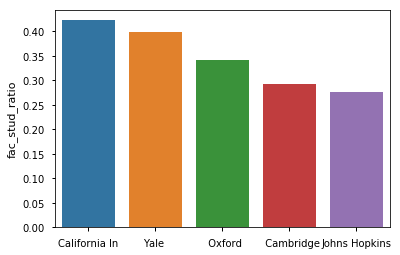

In [8]:
# format the name to fit in the bar plot
shorten_school_name = [x.replace('of', '').replace('University', '')[0:13] for x in sorted_by_facStudRatio.head().school_name]
ax = sns.barplot(x=shorten_school_name, y=sorted_by_facStudRatio.head().fac_stud_ratio)

This is the top 5 university in terms of faculty/student ratio. 

### 1.b - Best university in terms of ratio of international students

We use strategy that is exactly the same than for the 1.a

In [9]:
df_topUni['international_ratio'] = df_topUni['international_student']/df_topUni['total_student']
sorted_by_internationalRatio = df_topUni.sort_values('international_ratio',ascending=False)
sorted_by_internationalRatio.head()

,school_name,total_staff,international_staff,total_student,international_student,country,region,fac_stud_ratio,international_ratio
rank,,,,,,,,,
35,London School of Economics and Political Scien...,1088.0,687.0,9760.0,6748.0,United Kingdom,Europe,0.111475,0.691393
12,Ecole Polytechnique Fédérale de Lausanne (EPFL),1695.0,1300.0,10343.0,5896.0,Switzerland,Europe,0.163879,0.570047
8,Imperial College London,3930.0,2071.0,16090.0,8746.0,United Kingdom,Europe,0.244251,0.543567
200,Maastricht University,1277.0,502.0,16385.0,8234.0,Netherlands,Europe,0.077937,0.502533
47,Carnegie Mellon University,1342.0,425.0,13356.0,6385.0,United States,North America,0.100479,0.478062


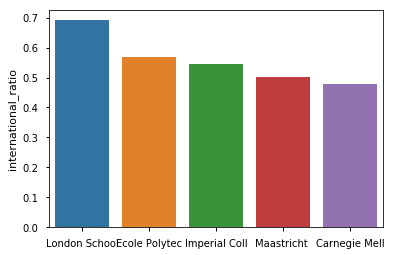

In [10]:
# format the name to fit in the bar plot
shorten_school_name = [x.replace('of', '').replace('University', '')[0:13] for x in sorted_by_internationalRatio.head().school_name]
ax = sns.barplot(x=shorten_school_name, y=sorted_by_internationalRatio.head().international_ratio)

This is the top 5 university in terms of international students/total students ratio. 

### 1.c - Aggregated by country

Because it wasn't so clear how we should aggregate the data, we decided to consider the ```mean()``` as aggregation function which will give us the ranking of countries according to :
* ratio of faculty staff over students
* ratio of international students

In [11]:
best_countries_by_facStudRatio = df_topUni.groupby('country').mean().sort_values('fac_stud_ratio',ascending=False)
best_countries_by_facStudRatio[['fac_stud_ratio']].head()

,fac_stud_ratio
country,
Russia,0.221910
Denmark,0.186580
Saudi Arabia,0.175828
Singapore,0.162279
Japan,0.155840


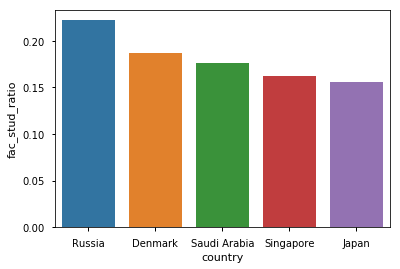

In [12]:
ax = sns.barplot(x=best_countries_by_facStudRatio.head().index, y=best_countries_by_facStudRatio.head().fac_stud_ratio)

This is the top 5 countries in terms of faculty/student ratio.

In [13]:
best_countries_by_internationalRatio = df_topUni.groupby('country').mean().sort_values('international_ratio',ascending=False)
best_countries_by_internationalRatio[['international_ratio']].head()

,international_ratio
country,
United Kingdom,0.351308
Australia,0.346878
Switzerland,0.313816
Hong Kong,0.312148
Austria,0.306095


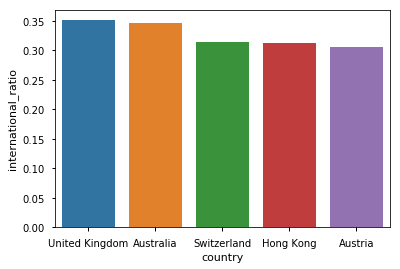

In [14]:
ax = sns.barplot(x=best_countries_by_internationalRatio.head().index, y=best_countries_by_internationalRatio.head().international_ratio)

This is the top 5 countries in terms of international students/total students ratio. 

### 1.d - Aggregated by region

Very similar strategy than the one used in 1.c

In [15]:
best_regions_by_facStudRatio = df_topUni.groupby('region').mean().sort_values('fac_stud_ratio',ascending=False)
best_regions_by_facStudRatio[['fac_stud_ratio']]

,fac_stud_ratio
region,
North America,0.144831
Asia,0.134673
Europe,0.120003
Latin America,0.096779
Africa,0.088450
Oceania,0.075003


In [16]:
best_regions_by_internationalRatio = df_topUni.groupby('region').mean().sort_values('international_ratio',ascending=False)
best_regions_by_internationalRatio[['international_ratio']]

,international_ratio
region,
Oceania,0.329077
Europe,0.245932
North America,0.202437
Africa,0.169703
Asia,0.132394
Latin America,0.071751


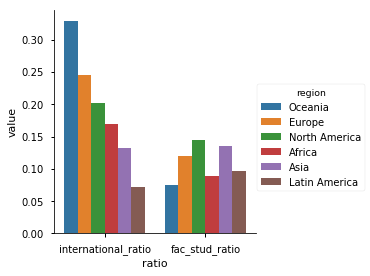

In [17]:
# format the dataframe to make a nice barplot
df = best_regions_by_internationalRatio[['international_ratio']].merge(best_regions_by_facStudRatio[['fac_stud_ratio']], left_index=True, right_index=True)
df.reset_index(inplace=True)
df = pd.melt(df, id_vars=['region'], var_name="ratio", value_name='value')
# plot the barplot with sns
ax = sns.factorplot(x='ratio', y='value', hue='region', data=df, kind='bar')

This is the 6 regions classified by international students ratio on the left and weighted with the faculty / students ratio on the right

## 2 - Times Higher Education

Because we do not have direct access to some informations (e.g. International Students, Total Staff) we will infer them using the informations we have.

In [18]:
def find_region_from_country(country):
    """
        use restcountries.eu API to return the region name from the country name
        
        @params:
        - country : the country to find the region from
    """
    # with further investigation we realised that South Korea is not recognized well by the API 
    # so we decided to handle that specific case separetly :
    if country == 'South Korea':
        return 'Asia'
    
    r = requests.get('https://restcountries.eu/rest/v2/name/' + country)
    
    try:
        region = r.json()[0]['region']
        if region == 'Americas':
            region = r.json()[0]['subregion']
    except(KeyError) as e:
        print("Couldn't find region for '{}'".format(country))
        region = np.nan
    
    return region


In [19]:
def get_ranking_times(path_to_dump):
    """
        generate a dataframe with the top 200 university from timeshighereducation.com
        
        @params:
        - path_to_dump : path were the dump of the data should be (will use it if already present and save there otherwise)
    """
    if(os.path.isfile(path_to_dump)):
        return pd.read_pickle(path_to_dump)
    
    r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')

    top_200 = []
    for (i,uni_dict) in enumerate(r.json()['data']):
        if(i>=200):
            break
        title = uni_dict['name']
        # We delete the '=' sign in the case of tie to be consistent with the first one
        rank = uni_dict['rank'].replace('=','')
        country = uni_dict['location']

        # We delete the thousands separator
        student_total = int(uni_dict['stats_number_students'].replace(',',''))
        pc_inter_student = float(uni_dict["stats_pc_intl_students"].replace('%',''))/100
        student_to_staff_ratio = float(uni_dict["stats_student_staff_ratio"])

        # infer some informations using the percentage and ratio
        student_inter = student_total*pc_inter_student
        staff_total = student_total/student_to_staff_ratio

        top_200.append({'school_name': title, 
                            'rank': rank, 
                            'country': country,
                            'international_student' : int(round(student_inter)),
                            'total_staff' : int(round(staff_total)),
                            'total_student': student_total,
                            'region': find_region_from_country(country)
                           })
        
        # update the progress bar
        progress(i+1,200,'Analysing the JSON file')
        
    df = pd.DataFrame.from_dict(top_200)
    
    # We set Rank as an index
    df.set_index('rank',inplace=True)
    
    # Reorder the df columns for better output
    df = df[['school_name', 'total_staff', 'total_student', 'international_student', 'country', 'region']]

    df.to_pickle(path_to_dump)
    return df

In [20]:
df_times = get_ranking_times('times_backup')
df_times.head()

,school_name,total_staff,total_student,international_student,country,region
rank,,,,,,
1,University of Oxford,1822,20409,7755,United Kingdom,Europe
2,University of Cambridge,1687,18389,6436,United Kingdom,Europe
3,California Institute of Technology,340,2209,596,United States,Northern America
3,Stanford University,2113,15845,3486,United States,Northern America
5,Massachusetts Institute of Technology,1285,11177,3800,United States,Northern America


We now repeat the same steps as for the first exercise to analyse the different ratio such as faculty/student ratio and international/total students.

### 2.a - Best university in terms of ratio faculty members over students

In [21]:
df_times['fac_stud_ratio'] = df_times['total_staff']/df_times['total_student']
sorted_by_facStudRatio = df_times.sort_values('fac_stud_ratio',ascending=False)
sorted_by_facStudRatio.head()

,school_name,total_staff,total_student,international_student,country,region,fac_stud_ratio
rank,,,,,,,
105,Vanderbilt University,3640,12011,1561,United States,Northern America,0.303056
109,University of Copenhagen,7413,30395,4255,Denmark,Europe,0.243889
12,Yale University,2827,12155,2553,United States,Northern America,0.232579
153,University of Rochester,2241,9636,2794,United States,Northern America,0.232565
13,Johns Hopkins University,3604,15498,3720,United States,Northern America,0.232546


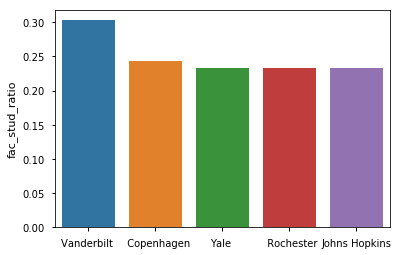

In [22]:
# format the name to fit in the bar plot
shorten_school_name = [x.replace('of', '').replace('University', '')[0:13] for x in sorted_by_facStudRatio.head().school_name]
ax = sns.barplot(x=shorten_school_name, y=sorted_by_facStudRatio.head().fac_stud_ratio)

We can observe that in this ranking the rank compare to the faculty/student ratio is much higher. The best faculty/student ratio is only rank 105 when it was 4 in the other ranking. We also observe that the value differ from the previous ranking and that we see only 2 universities in common in the top 5 (Yale and Johns Hopkins).

### 2.b - Best university in terms of ratio of international students

In [23]:
df_times['international_ratio'] = df_times['international_student']/df_times['total_student']
sorted_by_internationalRatio = df_times.sort_values('international_ratio',ascending=False)
sorted_by_internationalRatio.head()

,school_name,total_staff,total_student,international_student,country,region,fac_stud_ratio,international_ratio
rank,,,,,,,,
25,London School of Economics and Political Science,825,10065,7146,United Kingdom,Europe,0.081967,0.709985
179,University of Luxembourg,340,4969,2832,Luxembourg,Europe,0.068424,0.569934
8,Imperial College London,1391,15857,8721,United Kingdom,Europe,0.087722,0.549978
38,École Polytechnique Fédérale de Lausanne,886,9928,5460,Switzerland,Europe,0.089243,0.549960
103,Maastricht University,929,16727,8364,Netherlands,Europe,0.055539,0.500030


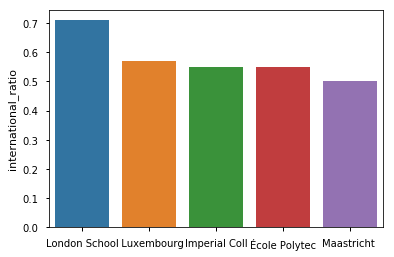

In [24]:
# format the name to fit in the bar plot
shorten_school_name = [x.replace('of', '').replace('University', '')[0:13] for x in sorted_by_internationalRatio.head().school_name]
ax = sns.barplot(x=shorten_school_name, y=sorted_by_internationalRatio.head().international_ratio)

For the international ratio we observe this time comparable result that the one we had with the previous ranking. Only the luxembourg university came in the top 5 and wasn't here before.

### 2.c - Aggregated by country

In [25]:
best_countries_by_facStudRatio = df_times.groupby('country').mean().sort_values('fac_stud_ratio',ascending=False)
best_countries_by_facStudRatio[['fac_stud_ratio']].head()

,fac_stud_ratio
country,
Denmark,0.160176
Italy,0.138870
Russian Federation,0.136989
Japan,0.132105
United States,0.106393


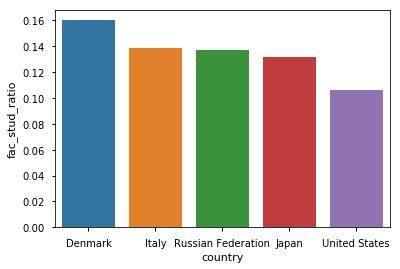

In [26]:
ax = sns.barplot(x=best_countries_by_facStudRatio.head().index, y=best_countries_by_facStudRatio.head().fac_stud_ratio)

Yet again for the faculty/student ratio by country, we observe comparable result as before only with Singapour and Saudi Arabia out replaced by Italy and United states.

In [27]:
best_countries_by_internationalRatio = df_times.groupby('country').mean().sort_values('international_ratio',ascending=False)
best_countries_by_internationalRatio[['international_ratio']].head()

,international_ratio
country,
Luxembourg,0.569934
United Kingdom,0.365478
Hong Kong,0.327989
Switzerland,0.314280
Australia,0.307502


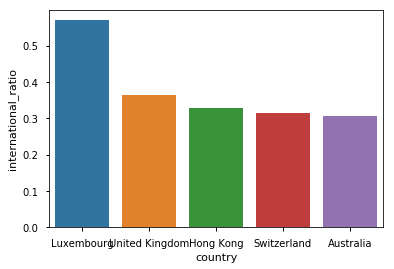

In [28]:
ax = sns.barplot(x=best_countries_by_internationalRatio.head().index, y=best_countries_by_internationalRatio.head().international_ratio)

We can observe only little change herwith luxembourg instead of Austria.

### 2.d - Aggregated by region

In [29]:
best_regions_by_facStudRatio = df_times.groupby('region').mean().sort_values('fac_stud_ratio',ascending=False)
best_regions_by_facStudRatio[['fac_stud_ratio']]

,fac_stud_ratio
region,
Northern America,0.101658
Africa,0.085487
Asia,0.080347
Europe,0.065951
Oceania,0.039893


In [30]:
best_regions_by_internationalRatio = df_times.groupby('region').mean().sort_values('international_ratio',ascending=False)
best_regions_by_internationalRatio[['international_ratio']]

,international_ratio
region,
Oceania,0.305558
Europe,0.244658
Northern America,0.185585
Africa,0.180024
Asia,0.165242


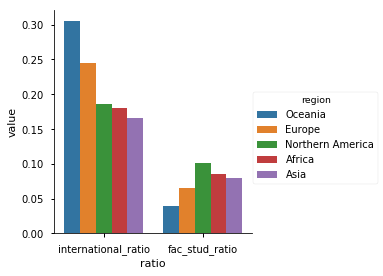

In [31]:
# format the dataframe to make a nice barplot
df = best_regions_by_internationalRatio[['international_ratio']].merge(best_regions_by_facStudRatio[['fac_stud_ratio']], left_index=True, right_index=True)
df.reset_index(inplace=True)
df = pd.melt(df, id_vars=['region'], var_name="ratio", value_name='value')
# plot the barplot with sns
ax = sns.factorplot(x='ratio', y='value', hue='region', data=df, kind='bar')

At the end we observe very comparable result on the international ratio by region but the faculty/student ratio by range seems to have drastically change. We can also note that this ranking doesn't have any universty in the south america part in the top 200.

## 3 - Merging the two data frames
### 3.1 - Matching the school names